In [1]:
from collections import OrderedDict,Counter
from kmapper.plotlyviz import *
import gower as gw
import pandas as pd
import math
from sklearn.metrics.pairwise import cosine_distances,pairwise_distances
from sklearn import preprocessing
import seaborn as sb
import matplotlib.pyplot as plt
import umap.umap_ as umap
from umap.parametric_umap import ParametricUMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS, SpectralEmbedding
import tensorflow as tf
import kmapper as km
import ast
from sklearn.cluster import AgglomerativeClustering,SpectralClustering,DBSCAN
import networkx as nx
import warnings
warnings.filterwarnings('ignore')
import time

## Distance matrix calculation

In [2]:
def distance_matrix(patient_id, Y_class, dataset,continue_features, visualize, distance_matrix_path):
    """
    Function for distance matrix calculation, according to the features' type
    INPUT:
        - patient_id:           (pandas Series) dataset's column indicating the samples IDs
        - Y_class:              (pandas Series) dataset's column indicating the binarized output (phenotypes)
        - dataset               (pandas DataFrame) dataset for which calculate the distance
        - continue_features     (list) list containing the dataset's numerical features
        - visualize             (boolean) flag to specify that the distance matrix will be plotted with a heatmap
        - distance_matrix_path  (string)  path in which the distance matrix will be saved as .npy
    OUTPUT:
        - distance_matrix       (numpy ndarray) patients distance matrix
    """
    
    # filter the dataset in order to delete the IDs and the output columns
    dataset_features = dataset.loc[:, ~dataset.columns.isin([patient_id.name,Y_class.name])]
    
    # find all the categorical variables
    bool_categorical = []
    for features in list(dataset_features.columns):
        if features in continue_features:
            bool_categorical.append(False)
        else:
            bool_categorical.append(True)
    
    # only categorical variables -> Jaccard distance
    if sum(bool_categorical) == 0:
        print("only categorical variables -> Jaccard distance")
        
        # make the categorical variables as dummies
        df_categorical_dummies = pd.get_dummies(dataset_features.astype(str),drop_first=True)
        distance_matrix = pairwise_distances(df_categorical_dummies.values, metric = "jaccard")
    
    
    # both categorical and continue variables -> Gower distance
    elif sum(bool_categorical)>0 and sum(bool_categorical)!=len(bool_categorical):
        print("both categorical and continue variables -> Gower distance")
        
        # the gower package already creates dummy variables and standardize numerical variables
        distance_matrix = gw.gower_matrix(dataset_features,cat_features=bool_categorical)
        
        
    # only numerical variables -> cosine distance 
    elif sum(bool_categorical)==len(bool_categorical):
        print("only numerical variables -> cosine distance")
        
        # scaling the numerical features in [0,1] range
        X = dataset_features.values
        min_max_scaler = preprocessing.MinMaxScaler()
        X_scaled = min_max_scaler.fit_transform(X)
        dataset_scaled= pd.DataFrame(X_scaled, columns = dataset_features.columns)

        distance_matrix = cosine_distances(dataset_scaled,dataset_scaled)

    # visualize distance matrix as a heatmap
    if visualize:
        fig = plt.figure(figsize=(11,8))
        sb.heatmap(distance_matrix)
        
    # save the distance matrix as .npy file
    np.save(distance_matrix_path,distance_matrix,allow_pickle=False)
    
    return distance_matrix

both categorical and continue variables -> Gower distance


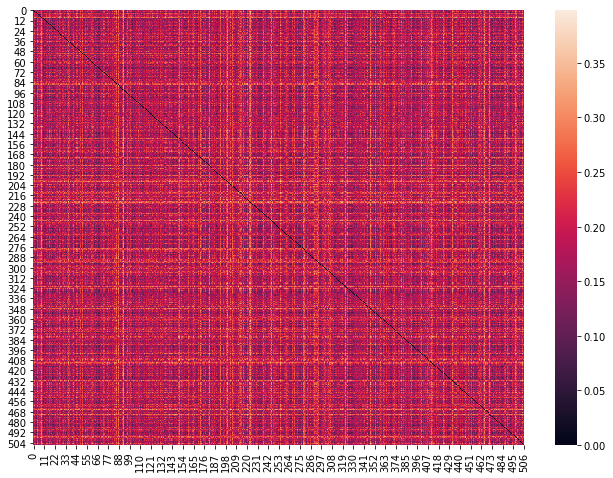

In [3]:
# read the training set
trainingset_experiment = pd.read_excel("data/trainingset_experiment.xlsx")

# create a list with the dataset numerical variables 
continue_features=  ["Age","Height","Weight","BMI","Systolic_blood_pressure","Diastolic_blood_pressure",'Heart_rate',
                  'Abdominal_circumference','Pelvis_circumference',  'Oxygen_saturation', "Years_as_a_smoker",
                    "Leukocytes","Erythrocytes","Haemoglobin","Haematocrit","MCV","MCH","MCHC","RDW","Platelets","MPV",
               'Neutrophils_%', 'Lymphocytes_%', 'Monocytes_%', 'Eosinophils_%', 'Basophils_#',
                  'Neutrophils_#', 'Lymphocytes_#', 'Monocytes_#', 'Eosinophils_#', 'Basophils_%', 'Blood_sugar', 
                  'Uric_acid', 'GGT', 'Total_bilirubin', 'hsTnI', 'Triglycerides','Total_cholesterol', 'HDL_cholesterol',
                  'LDL_cholesterol', 'CRP', 'hs-CRP', 'HbA1c-IFCC', 'HbA1c-DCCT']


distance_matrix = distance_matrix(trainingset_experiment['PATIENT_ID'],trainingset_experiment['Y_class'],
                                  trainingset_experiment.loc[:, ~trainingset_experiment.columns.isin(['CUORE_10yCV_riskscore'])],
                                  continue_features,True,"data/trainingset_distance_matrix.npy")
#distance_matrix = np.load("exp1/data/trainingset_distance_matrix_exp1.npy")

# specify the random state
rnd = 203

# specify some tensorflow options for the neural networks training 
keras_fit_kwargs = {"callbacks": [tf.keras.callbacks.EarlyStopping(
                                          monitor='loss',
                                          min_delta=10**-2,
                                          patience=3,
                                          verbose=1)  ]}

## Grid search (first step) for lens hyperparameters tuning

In [70]:
def entropy_count(scomplex,binary_class):
    """
    Function for computing the graph entropy.
    INPUT:
       - scomplex:     (dictionary) simplicial complex resulting from the application of KeplerMapper
       - binary_class: (pandas Series) dataset's column indicating the binarized output (phenotypes)
    OUTPUT:
       - Binary_entropy: (float) graph entropy (mean average nodes entropy)
    """
    
    kmgraph = get_mapper_graph(scomplex)
    # assign to node['custom_tooltips']  the node label
    for node in kmgraph[0]['nodes']:
        node['binary'] = binary_class[scomplex['nodes'][node['name']]]
    Binary_entropy_node ={}
    
    # extract nodes properties such as size and how many samples for each class
    for j, node in enumerate(kmgraph[0]['nodes']):   
        dimCluster = node['cluster']['size']
        
        data_bin = node['binary']
        dimData0 = len(data_bin.loc[data_bin==0])
        dimData1 = len(data_bin.loc[data_bin==1])

        # the nodes contains patients from both classes, so compute the binary entropy
        if dimData0 != 0 and dimData1 !=0:
            Bin_H_node = -((dimData0/dimCluster)*math.log2(dimData0/dimCluster)+(dimData1/dimCluster)*math.log2(dimData1/dimCluster))
        # the node contains only patients from one class
        elif dimData0 == 0 or dimData1 ==0:
            Bin_H_node = 0.0   # since 1*math.log2(1) = 0
            
        Binary_entropy_node[j] = [dimCluster, Bin_H_node]
        
    # compute the average weighted binary entropy -> graph entropy        
    sumBinEntropies = 0
    numberData = 0
    for j, node in enumerate(Binary_entropy_node):
        sumBinEntropies += (Binary_entropy_node[j][0]*Binary_entropy_node[j][1])
        numberData += Binary_entropy_node[j][0]
    Binary_entropy = sumBinEntropies/numberData
    
    return Binary_entropy


def do_hist_counter(scomplex):
    """
    Function to calculate the nodes size distribution.
    INPUT:
       - scomplex: (dictionary) simplicial complex resulting from the application of KeplerMapper
    OUTPUT:
       - counter:  (list) list of integer containing the distribution of the nodes size
       - n_nodes:  (int)  number of graph nodes
       - n_edges:  (int)  number of graph edges
       - n_unique: (int)  number of unique samples (patients) that results in the simplicial commplex
    """    
    kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex,
                                                                 color_function_name='Distance to x-min')

    n_nodes = mapper_summary['n_nodes']
    n_edges = mapper_summary['n_edges']
    n_unique = mapper_summary['n_unique']
    
    counter = list()
    for j, node in enumerate(kmgraph['nodes']):
        counter.append(node["cluster"]["size"])

    return counter,n_nodes,n_edges,n_unique

In [71]:
def lenses_and_hyperparameters_greedy_search(distance_matrix,lens_names, projection_dimension,
                                              n_iterations_mds,max_iterations,epses,
                                              perplexities,learning_rates,n_iters,
                                              min_dists,n_neighbors,
                                              n_neurons,n_layers,nlayerdeep,nneurons_start,       
                                              n_cubes,perc_overlap,cluster_methods,
                                              rnd,binary_class, biological_features, path_grid_search_results):
    """
    Function for the lens functions and their hyperparameters grid search. 
    The execution time (in minutes) is printed at the end.
    INPUT:
       - distance_matrix:      (numpy ndarray) patients distance matrix
       - lens_names:           (list) list with the lens functions to include in the grid search
       - projection_dimension: (int) integer that indicates the number of dimensios of the projected space
       
       MDS parameters as sklearn
       - [ n_iterations_mds (list of int) ; max_iterations (list of int)  ; epses (list of float) ]
       t-SNE parameters as sklearn
       - [ perplexities (list of int) ; learning_rates (list of int) ; n_iters (list of int) ]
       UMAP parameters as umap-learn
       - [ min_dists (list of float) ; n_neighbors (list of int) ]
       UMAPnn (encoder as ParametricUMAP) parameters as umap-learn
       - [ n_neurons (list of int) ; n_layers (list of int) ]
       UMAPae (autoencoder as ParametricUMAP) parameters as umap-learn
       - [ nlayerdeep (list of int) ; nneurons_start (list of int) ]
       
       - n_cubes:         (list of int) list of number of hypercubes for each project dimensions, i.e. resolution
       - perc_overlap:    (list of float) list of percentages of overalap, i.e. gain
       - cluster_methods: (list of sklearn cluster methods) list of cluster methods to use in the grid search
       
       - rnd: (int) seed for reproducible output
       - binary_class: (pandas Series) dataset's column indicating the binarized output (phenotypes)
       - biological_features: (pandas DataFrame) a DataFrame with two columns to use as biological lens.
                              The first column will be used as projection with l2 if specifying "Bio_l2" lens;  
                              Both columns will be used as projections if specifying "Bio_bio" lens.
       - path_grid_search_results: (string) path in which the output dataframe will be saved
    OUTPUT:
       - grid_search_results_df: (pandas DataFrame) report of the grid search 
    """
    
    # start by creating an empy dataframe. This will be appended with the grid search combinations of parameters and graph statistics
    grid_search_results_df = pd.DataFrame(columns = ["lens_name","parameters_combination",
                            "n_nodes","n_edges","n_unique","binary_cross_entropy",
                            "node_size_distribution_values", "mean_size",
                            "nodes_degree", "mean_degree", "density"])
    st = time.time()
    mapper = km.KeplerMapper()    

    # cicle on all the lens functions specified in the list. 
    # For each functions all the parameters combination are tried, a projection lens in created and the dataset is projected
    # then the projection are used by the 'Mapper_hyperparameters_greedy_search' functions to create the graph
    
    for lens in lens_names:
        
        print("lens: "+str(lens))
        
        if lens=="MDS":
            for n_it in n_iterations_mds:
                for max_it in max_iterations:
                    for eps in epses:
                        print("n_iterations: "+ str(n_it)+"; max_iterations: "+ str(max_it) +"; eps: "+ str(eps)   )
                        projection = mapper.project(distance_matrix, projection=MDS(n_components=projection_dimension, random_state=rnd,n_init=n_it,max_iter=max_it,eps=eps, metric=True,dissimilarity="precomputed"), distance_matrix = None, scaler = None)
                        
                        parameters_combination_string = str("n_iterations: "+ str(n_it)+"; max_iterations: "+ str(max_it) +"; eps: "+ str(eps)   ) 
                        grid_search_results_df = Mapper_parameters_greedy_search(distance_matrix,mapper,projection,
                                                         n_cubes,perc_overlap,cluster_methods, 
                                                         lens, parameters_combination_string,grid_search_results_df,binary_class,True)
                
        if lens=="PCA":
            projection = mapper.project(distance_matrix, projection=PCA(n_components=projection_dimension, random_state=rnd), distance_matrix = None, scaler = None)
            
            parameters_combination_string = "-" 
            grid_search_results_df = Mapper_parameters_greedy_search(distance_matrix,mapper,projection,
                                                         n_cubes,perc_overlap,cluster_methods, 
                                                         lens, parameters_combination_string,grid_search_results_df,binary_class,True)
                
            
        if lens=="tSNE":
            for p in perplexities:
                for l in learning_rates:
                    for i in n_iters:
                        print("perplexity: "+ str(p)+"; learning_rates: "+ str(l) +"; n_iters: "+ str(i)   )
                        projection = mapper.project(distance_matrix, projection= TSNE(n_components=projection_dimension, random_state=rnd, perplexity = p , learning_rate= l , n_iter= i,init="random",metric="precomputed"),distance_matrix = None, scaler = None)

                        parameters_combination_string = str("perplexity: "+ str(p)+"; learning_rates: "+ str(l) +"; n_iters: "+ str(i)) 
                        grid_search_results_df = Mapper_parameters_greedy_search(distance_matrix,mapper,projection,
                                                         n_cubes,perc_overlap,cluster_methods, 
                                                         lens, parameters_combination_string,grid_search_results_df,binary_class,True)
                
    
                        
        if lens=="UMAP": 
            for n in n_neighbors:
                for d in min_dists:
                    print("min_dists: "+ str(d)+"; n_neighbors: "+ str(n))
                    projection = mapper.project(distance_matrix, projection= umap.UMAP(n_components=projection_dimension, random_state=rnd, n_neighbors= n, min_dist=d,metric="precomputed"),distance_matrix = None, scaler = None)

                    parameters_combination_string = str("min_dists: "+ str(d)+"; n_neighbors: "+ str(n)) 
                    grid_search_results_df = Mapper_parameters_greedy_search(distance_matrix,mapper,projection,
                                                         n_cubes,perc_overlap,cluster_methods, 
                                                         lens, parameters_combination_string,grid_search_results_df,binary_class,True)

                        
        
        if lens=="UMAPnn": 
            
            for nN in n_neurons:
                for nl in n_layers:
                    print("n_neurons: "+ str(nN)+"; n_layers: "+ str(nl))
                    parameters_combination_string = str("n_neurons: "+ str(nN)+"; n_layers: "+ str(nl)) 
                    
                    encoder = tf.keras.Sequential([
                
                    tf.keras.layers.InputLayer(input_shape=distance_matrix.shape[1]),
                    tf.keras.layers.Flatten()])
                    
                    for nn in range(nl):
                
                        encoder.add(tf.keras.layers.Dense(units=nN, activation="relu"))
                    
                    encoder.add(tf.keras.layers.Dense(units=projection_dimension, name="z"))
                
            
                    projection = mapper.project(distance_matrix, projection= ParametricUMAP(keras_fit_kwargs = keras_fit_kwargs,encoder=encoder),distance_matrix = None, scaler = None)
                    grid_search_results_df = Mapper_parameters_greedy_search(distance_matrix,mapper,projection,
                                                         n_cubes,perc_overlap,cluster_methods, 
                                                         lens, parameters_combination_string,grid_search_results_df,binary_class,True)
            
        if lens=="UMAPae":
        
                
            for ndeep in nlayerdeep:
                for init_dim in nneurons_start:
                    
                    print("nlayerdeep: "+ str(ndeep)+"; nneurons_start: "+ str(init_dim))
                    parameters_combination_string = str("nlayerdeep: "+ str(ndeep)+"; nneurons_start: "+ str(init_dim)) 
                    
                    encoder = tf.keras.Sequential([
                
                    tf.keras.layers.InputLayer(input_shape=distance_matrix.shape[1]),
                    tf.keras.layers.Flatten()])
            
                    decoder = tf.keras.Sequential([
                
                    tf.keras.layers.InputLayer(input_shape=projection_dimension)])
                    
                    start_dim = init_dim
                    reverse_start_dim = init_dim/(2**(ndeep-1))
                    for nn in range(ndeep):
                
                        encoder.add(tf.keras.layers.Dense(units=int(start_dim), activation="relu"))
                        start_dim = start_dim/2
                
                        decoder.add(tf.keras.layers.Dense(units=int(reverse_start_dim), activation="relu"))
                        reverse_start_dim = reverse_start_dim*2
                        
                    
                    encoder.add(tf.keras.layers.Dense(units=projection_dimension, name="z"))
                    decoder.add(tf.keras.layers.Dense(units=np.product(distance_matrix.shape[1]), name="recon", activation=None))
                    decoder.add(tf.keras.layers.Reshape((distance_matrix.shape[1],1)))
                
        
                    projection = mapper.project(distance_matrix, projection= ParametricUMAP(keras_fit_kwargs = keras_fit_kwargs,parametric_reconstruction= True,autoencoder_loss = True,encoder=encoder,decoder=decoder),distance_matrix = None, scaler = None)
                    grid_search_results_df = Mapper_parameters_greedy_search(distance_matrix,mapper,projection,
                                                         n_cubes,perc_overlap,cluster_methods, 
                                                         lens, parameters_combination_string,grid_search_results_df,binary_class,True)
     
    
        if lens=="Bio_l2":
            
                print(biological_features.iloc[:,0].name + "l2 norm")
                parameters_combination_string = biological_features.iloc[:,0].name
            
                bio_feature = np.array(biological_features.iloc[:,0]).reshape((biological_features.iloc[:,0].shape[0], 1))
                lens2 = mapper.fit_transform(distance_matrix, projection="l2norm", distance_matrix = None, scaler = None)
                projection = np.c_[lens2, bio_feature]
                
                grid_search_results_df = Mapper_parameters_greedy_search(distance_matrix,mapper,projection,
                                                         n_cubes,perc_overlap,cluster_methods, 
                                                         lens, parameters_combination_string,grid_search_results_df,binary_class,True)
     
        if lens=="Bio_bio":
                print(biological_features.iloc[:,0].name + " " + biological_features.iloc[:,1].name)
                parameters_combination_string = biological_features.iloc[:,0].name + " " + biological_features.iloc[:,1].name
    
                bio_feature_1 = np.array(biological_features.iloc[:,0]).reshape((biological_features.iloc[:,0].shape[0], 1))
                bio_feature_2 = np.array(biological_features.iloc[:,1]).reshape((biological_features.iloc[:,1].shape[0], 1))
                projection = np.c_[bio_feature_1, bio_feature_2]
                
                grid_search_results_df = Mapper_parameters_greedy_search(distance_matrix,mapper,projection,
                                                         n_cubes,perc_overlap,cluster_methods, 
                                                         lens, parameters_combination_string,grid_search_results_df,binary_class,True)
     
    
    
    grid_search_results_df.to_excel(path_grid_search_results,index=False)
    
    et = time.time()
    elapsed_time = (et - st)/60
    print('Execution time:', elapsed_time, 'minutes')
    
    return grid_search_results_df



def Mapper_parameters_greedy_search(distance_matrix,mapper,projection,
                         n_cubes,perc_overlap,cluster_methods,
                        lens, parameters_string_combination, grid_search_results_df,binary_class,flag_remove_duplicate_nodes):
    """
    Function for the Mapper parameters (resolution, gain and clustering algorithm) grid search. 
    INPUT: 
       - distance_matrix:               (numpy ndarray) patients distance matrix
       - mapper:                        (KeplerMapper object)
       - projection:                    (numpy ndarray) projections obtained with KeplerMapper method 'mapper.project'
       - n_cubes:                       (list of int) list of number of hypercubes for each project dimensions, i.e. resolution
       - perc_overlap:                  (list of float) list of percentages of overalap, i.e. gain
       - cluster_methods:               (list of sklearn cluster methods) list of cluster methods to use in the grid search
       - lens:                          (string) lens functions name
       - parameters_string_combination: (string) string containing the lens functions hyperparameters combination
       - grid_search_results_df:        (pandas DataFrame) report of the grid search 
       - binary_class:                  (pandas Series) dataset's column indicating the binarized output (phenotypes)
       - flag_remove_duplicate_nodes:   (boolean) flag used to specify if the KeplerMapper will create a graph in which duplicates nodes are excluded
    OUTPUT:
       - grid_search_results_df:        (pandas DataFrame) report of the grid search
    """
    
    # for each combination of mapper parameters apply the cover with the KeplerMapper method '.Cover', 
    # then compute the graph entropy, distribution of nodes size and graph statistics
    for cub in n_cubes:
        for over in perc_overlap:
            for method in cluster_methods:
              
                string_to_return_parameters_mapper = str("; n_cubes: "+ str(cub)+  ";perc overlap: "+  str(over)   +"; cluster method: "+ str(method))
                print("n_cubes: "+ str(cub)+  ";perc overlap: "+  str(over)   +"; cluster method: "+ str(method))
                
                # recognize if the method is spectral clustering by using substring
                if str(method)[0:18] == "SpectralClustering":
                    
                    scomplex = mapper.map(projection, 1-distance_matrix, 
                    cover=km.Cover(n_cubes=cub, perc_overlap=over), clusterer=method,  precomputed=True,
                                         remove_duplicate_nodes = flag_remove_duplicate_nodes)
                else:
                    scomplex = mapper.map(projection, distance_matrix, 
                    cover=km.Cover(n_cubes=cub, perc_overlap=over), clusterer=method,  precomputed=True,
                                         remove_duplicate_nodes = flag_remove_duplicate_nodes)
                
                # compute the graph entropy
                binary_cross_entropy = entropy_count(scomplex,binary_class)
                # compute the distribution of the nodes size
                node_size_distribution_values,n_nodes,n_edges,n_unique = do_hist_counter(scomplex)   
        
                # return a networkx graph object from the KeplerMapper simplicial complex
                G = km.adapter.to_nx(scomplex)
                
                # compute graph statistics 
                mean_size = np.mean(node_size_distribution_values)
                nodes_degree = [G.degree[n] for n in G.nodes]
                mean_degree = np.mean(nodes_degree)
                density = nx.density(G)
                
                grid_search_results_df = grid_search_results_df.append({"lens_name":lens,
                            "parameters_combination":parameters_string_combination + string_to_return_parameters_mapper,
                            "n_nodes":n_nodes,"n_edges":n_edges,"n_unique":n_unique,
                            "binary_cross_entropy":binary_cross_entropy,
                            "node_size_distribution_values":node_size_distribution_values,
                            "mean_size":mean_size,
                            "nodes_degree":nodes_degree, "mean_degree":mean_degree,
                            "density":density },ignore_index=True)
                
                
    return grid_search_results_df
            


In [7]:
# we perform the grid search by specifying the lens functions names and their hyperparameters
grid_search_results_df = lenses_and_hyperparameters_greedy_search(distance_matrix,
                  ['PCA','tSNE','UMAP','UMAPnn','UMAPae'], 2,
                  [],[],[],
                  np.arange(15,55,10),np.arange(300,1000,300),np.array([1500]),
                  np.array([0.25,0.5,0.75,0.9]),np.array([5,10,25,50,120,150,200]),
                  np.array([100,200]),np.array([3,5]),  
                  np.array([3,4]),np.array([200,400]),       
                  np.array([18]),np.array([0.5]), 
                  [AgglomerativeClustering(affinity='precomputed', linkage='complete')],
                  rnd,trainingset_experiment['Y_class'], trainingset_experiment[["CUORE_10yCV_riskscore",'Age']], "results/lens_parameters_grid_search.xlsx")

lens: PCA
n_cubes: 18;perc overlap: 0.5; cluster method: AgglomerativeClustering(affinity='precomputed', linkage='complete')
lens: tSNE
perplexity: 15; learning_rates: 300; n_iters: 1500
n_cubes: 18;perc overlap: 0.5; cluster method: AgglomerativeClustering(affinity='precomputed', linkage='complete')
perplexity: 15; learning_rates: 600; n_iters: 1500
n_cubes: 18;perc overlap: 0.5; cluster method: AgglomerativeClustering(affinity='precomputed', linkage='complete')
perplexity: 15; learning_rates: 900; n_iters: 1500
n_cubes: 18;perc overlap: 0.5; cluster method: AgglomerativeClustering(affinity='precomputed', linkage='complete')
perplexity: 25; learning_rates: 300; n_iters: 1500
n_cubes: 18;perc overlap: 0.5; cluster method: AgglomerativeClustering(affinity='precomputed', linkage='complete')
perplexity: 25; learning_rates: 600; n_iters: 1500
n_cubes: 18;perc overlap: 0.5; cluster method: AgglomerativeClustering(affinity='precomputed', linkage='complete')
perplexity: 25; learning_rates: 90

In [4]:
def read_grid_search_results(path_grid_search_results_df):
    """
    Function for reading the grid search results dataframe, saved as .xlsx.
    INPUT:
       - path_grid_search_results_df (string): path in which the grid search dataframe is saved
    OUTPUT:
       - grid_search_results_df      (pandas DataFrame): grid search results as a DataFrame
    """
    grid_search_results_df = pd.read_excel(path_grid_search_results_df)

    node_size_distribution_values = []
    nodes_degree = []

    # in order to correctly encode as list the excel cells that contains a list, we use the 'ast' package
    for index,row in grid_search_results_df.iterrows():

        node_size_distribution_values.append(ast.literal_eval(row['node_size_distribution_values']))
        nodes_degree.append(ast.literal_eval(row['nodes_degree']))

    grid_search_results_df['node_size_distribution_values'] = node_size_distribution_values
    grid_search_results_df['nodes_degree'] = nodes_degree
    
    return grid_search_results_df


def extract_parameters_from_string_and_project(lens,distance_matrix,parameters_string,projection_dimension,rnd,biological_features):
    """
    Function for extracing the hyperparameters combination from a row of the the grid search results dataframe.
    Then project the dataset with the lens and its hyperparameters combination.
    INPUT:
       - lens:                          (string) lens functions name
       - distance_matrix:               (numpy ndarray) patients distance matrix
       - parameters_string_combination: (string) string containing the lens functions hyperparameters combination
       - projection_dimension:          (int) integer that indicates the number of dimensios of the projected space
       - rnd:                           (int) seed for reproducible output
       - biological_features:           (pandas DataFrame) a DataFrame with two columns to use as biological lens.
                              The first column will be used as projection with l2 if specifying "Bio_l2" lens;  
                              Both columns will be used as projections if specifying "Bio_bio" lens.
    OUTPUT:
       - projection:                    (numpy ndarray) projections obtained with KeplerMapper method 'mapper.project'
    """
    mapper = km.KeplerMapper()
    
    print(lens)
    print(parameters_string)
    
    if lens=="MDS":
        n_iterations = int(parameters_string.split(";")[0].split(": ")[1])
        max_iterations = int(parameters_string.split(";")[1].split(": ")[1])
        epses = float(parameters_string.split(";")[2].split(": ")[1])
        projection = mapper.project(distance_matrix, projection=MDS(n_components=projection_dimension, random_state=rnd,n_init=n_iterations,max_iter=max_iterations,eps=epses, metric=True,dissimilarity="precomputed"), distance_matrix = None, scaler = None)
                        
    if lens=="PCA":
        projection = mapper.project(distance_matrix, projection=PCA(n_components=projection_dimension, random_state=rnd), distance_matrix = None, scaler = None)
    
    elif lens=="tSNE":
        p = int(parameters_string.split(";")[0].split(": ")[1])
        l = int(parameters_string.split(";")[1].split(": ")[1])
        i = int(parameters_string.split(";")[2].split(": ")[1])
        projection = mapper.project(distance_matrix, projection= TSNE(n_components=projection_dimension, random_state=rnd, perplexity = p , learning_rate= l , n_iter= i,init="random",metric="precomputed"),distance_matrix = None, scaler = None)
    
    elif lens=="UMAP":
        n = int(parameters_string.split(";")[1].split(": ")[1])
        d = float(parameters_string.split(";")[0].split(": ")[1])
        projection = mapper.project(distance_matrix, projection= umap.UMAP(n_components=projection_dimension, random_state=rnd, n_neighbors= n, min_dist=d,metric="precomputed"),distance_matrix = None, scaler = None)
   
    elif lens=="UMAPnn": 
        nN = int(parameters_string.split(";")[0].split(": ")[1])
        nl = int(parameters_string.split(";")[1].split(": ")[1])
        encoder = tf.keras.Sequential([
                
        tf.keras.layers.InputLayer(input_shape=distance_matrix.shape[1]),
        tf.keras.layers.Flatten()])
                    
        for nn in range(nl):
                
            encoder.add(tf.keras.layers.Dense(units=nN, activation="relu"))
                    
        encoder.add(tf.keras.layers.Dense(units=projection_dimension, name="z"))
                
            
        projection = mapper.project(distance_matrix, projection= ParametricUMAP(keras_fit_kwargs = keras_fit_kwargs,encoder=encoder),distance_matrix = None, scaler = None)
                    
    elif lens=="UMAPae":
        ndeep = int(parameters_string.split(";")[0].split(": ")[1])
        init_dim = int(parameters_string.split(";")[1].split(": ")[1])
        encoder = tf.keras.Sequential([
                
        tf.keras.layers.InputLayer(input_shape=distance_matrix.shape[1]),
        tf.keras.layers.Flatten()])
            
        decoder = tf.keras.Sequential([
                
        tf.keras.layers.InputLayer(input_shape=projection_dimension)])
                    
        start_dim = init_dim
        reverse_start_dim = init_dim/(2**(ndeep-1))
        for nn in range(ndeep):
                
            encoder.add(tf.keras.layers.Dense(units=int(start_dim), activation="relu"))
            start_dim = start_dim/2
                
            decoder.add(tf.keras.layers.Dense(units=int(reverse_start_dim), activation="relu"))
            reverse_start_dim = reverse_start_dim*2
                               
        encoder.add(tf.keras.layers.Dense(units=projection_dimension, name="z"))
        decoder.add(tf.keras.layers.Dense(units=np.product(distance_matrix.shape[1]), name="recon", activation=None))
        decoder.add(tf.keras.layers.Reshape((distance_matrix.shape[1],1)))
                
        projection = mapper.project(distance_matrix, projection= ParametricUMAP(keras_fit_kwargs = keras_fit_kwargs,parametric_reconstruction= True,autoencoder_loss = True,encoder=encoder,decoder=decoder),distance_matrix = None, scaler = None)
                   

    elif lens=="Bio_l2":
        bio_feature = np.array(biological_features.iloc[:,0]).reshape((biological_features.iloc[:,0].shape[0], 1))
        lens2 = mapper.fit_transform(distance_matrix, projection="l2norm", distance_matrix = None, scaler = None)
        projection = np.c_[lens2, bio_feature]
        
    elif lens=="Bio_bio":
        bio_feature_1 = np.array(biological_features.iloc[:,0]).reshape((biological_features.iloc[:,0].shape[0], 1))
        bio_feature_2 = np.array(biological_features.iloc[:,1]).reshape((biological_features.iloc[:,1].shape[0], 1))
        projection = np.c_[bio_feature_1, bio_feature_2]
    
    return projection


def grid_search_results_optimal_choice(path_grid_search_results_df,binary_class,distance_matrix,projection_dimension,rnd,biological_features,annotate):
    """
    Functions that reads the grid search results and plot them. 
    In particular, the function dispaly the lens functions projections (as a scatterplot), 
    the node size and the node degree distributions (as barplots) and the graph statistics (as a table).
    In addition, graph statistics are plotted for each lens and combinations of parameters (as scatterplots).
    INPUT:
       - path_grid_search_results_df:   (string) path in which the grid search dataframe is saved
       - binary_class:                  (pandas Series) dataset's column indicating the binarized output (phenotypes)
       - distance_matrix:               (numpy ndarray) patients distance matrix
       - projection_dimension:          (int) integer that indicates the number of dimensios of the projected space
       - rnd:                           (int) seed for reproducible output
       - biological_features:           (pandas DataFrame) a DataFrame with two columns to use as biological lens.
                              The first column will be used as projection with l2 if specifying "Bio_l2" lens;  
                              Both columns will be used as projections if specifying "Bio_bio" lens.
    """
    
    grid_search_results_df = read_grid_search_results(path_grid_search_results_df)
    
    c = 0
    lens_names = set(grid_search_results_df['lens_name'])
    

    # the first figure contains the projections, the distributions of the nodes size and degree and the graph statistics   
    fig = plt.figure(figsize=(8*len(lens_names),4.5*len(lens_names)))
        
    fig_table, ax_table = plt.subplots(1,1,figsize=(8*len(lens_names),len(lens_names)-1.7))
    fig_table.patch.set_visible(False)
    ax_table.axis('off')
    ax_table.axis('tight')
        
    subfig = fig.subfigures(nrows=1, ncols=len(lens_names))
        
    columns = tuple(lens_names) 
    rows = ['N nodes', 'N edges', 'N unique samples',
            'Binary entropy', 'Mean nodes size', 'Mean nodes degree', 'Density']
        
    cell_text = []
    for lens in lens_names:
        axs = subfig[c].subplots(nrows=3, ncols=1)
            
        min_entropy = round(float(grid_search_results_df[grid_search_results_df['lens_name']==lens]['binary_cross_entropy'].min()),4)
        min_entropy_index = grid_search_results_df[grid_search_results_df['lens_name']==lens]['binary_cross_entropy'].idxmin()
        param_min_entropy = grid_search_results_df.loc[min_entropy_index]['parameters_combination']
        node_n = grid_search_results_df.loc[min_entropy_index]['n_nodes']
        edge_n = grid_search_results_df.loc[min_entropy_index]['n_edges']
        unique_n = grid_search_results_df.loc[min_entropy_index]['n_unique']
        node_size_distribution_values = grid_search_results_df.loc[min_entropy_index]['node_size_distribution_values']
        mean_size = grid_search_results_df.loc[min_entropy_index]['mean_size']
        nodes_degree = grid_search_results_df.loc[min_entropy_index]['nodes_degree']
        mean_degree = grid_search_results_df.loc[min_entropy_index]['mean_degree']
        density = round(float(grid_search_results_df.loc[min_entropy_index]['density']),4)
            
        cell_text.append([node_n,edge_n,unique_n,min_entropy,mean_size,mean_degree,density])
            
        projection = extract_parameters_from_string_and_project(lens,distance_matrix,param_min_entropy,projection_dimension,rnd,biological_features)

        datadf = pd.DataFrame({"Dim1":projection[:,0],"Dim2":projection[:,1],"binary class":list(binary_class)})
        counter_node_size_distribution = Counter(node_size_distribution_values)
        node_size_distribution = OrderedDict(sorted(counter_node_size_distribution.items(), key=lambda kv: kv[0]))
        bar_nodes_size = pd.DataFrame({"Node size":node_size_distribution.keys(),"Frequency":node_size_distribution.values()})
        counter_node_degree_distribution = Counter(nodes_degree)
        node_degree_distribution = OrderedDict(sorted(counter_node_degree_distribution.items(), key=lambda kv: kv[0]))
        bar_nodes_degree = pd.DataFrame({"Node degree":node_degree_distribution.keys(),"Frequency":node_degree_distribution.values()})
            
        sb.set_theme(style="white")
        sb.scatterplot(data=datadf,x="Dim1",y="Dim2",hue="binary class",palette=["#7581DD","#DE0827"],s=60,ax=axs[0],legend=False)
            
        sb.set_theme(style="whitegrid")
        sb.barplot(data=bar_nodes_size,x="Node size",y="Frequency",ax=axs[1],palette=["#1f77b4"])
        sb.barplot(data=bar_nodes_degree,x="Node degree",y="Frequency",ax=axs[2],palette=["#1f77b4"])
        axs[0].set_title(lens,size=31)
        axs[0].set(ylabel=None)
        axs[0].set_xlabel("H(G) = " + str(min_entropy),size=29)
        axs[0].set_xticks([], [])
        axs[0].set_yticks([], [])
        axs[0].set_frame_on(False)

        axs[1].set_xlabel("Node size",size=22)
        axs[1].set_ylabel("Frequency",size=22)
        axs[2].set_xlabel("Node degree",size=22)
        axs[2].set_ylabel("Frequency",size=22)
            
        if c==len(lens_names)-1:
            c=0
        else:
            c+=1
        
    table = ax_table.table(cellText=cell_text,
                            rowLabels=columns,
                            colLabels=rows,
                            colWidths=[0.09,0.09,0.18,0.15,0.19,0.21 , 0.09],
                            loc='top')
    table.scale(1,4)
    table.auto_set_font_size(False)
    table.set_fontsize(18)
    
    plt.savefig("results/lens_projections_results.png",dpi=300,bbox_inches='tight')
               
    #the second figure contains the graph statistics subplot for each combination of the lens functions parameters.
    sb.set(font_scale=1.4)
    fig, ax = plt.subplots(1,5,figsize=(22,6))
    fig.tight_layout(pad=3.0)
    sb.set_theme(style="whitegrid")
                                                           
    x_axis_to_plot = ["n_nodes","mean_size","mean_degree","density","n_nodes"]
    y_axis_to_plot = ["n_edges","n_nodes","n_nodes","n_edges","density"]
    axis_labels = {"n_nodes":"number of nodes",
                    "n_edges":"number of edges",
                    "mean_size":"nodes mean size",
                    "mean_degree":"nodes mean degree",
                    "density":"graph density"}
                                       
                                                   
    for n_plots in range(len(x_axis_to_plot)):
        scatterplot = sb.scatterplot(data = grid_search_results_df,x=x_axis_to_plot[n_plots],y=y_axis_to_plot[n_plots],hue='lens_name',s=120,ax=ax[n_plots],style="lens_name" ,legend=True)
        ax[n_plots].set_xticklabels([str(round(i,3)) for i in ax[n_plots].get_xticks()])
        plt.setp(scatterplot.get_legend().get_texts(), fontsize=16)
        plt.legend(title = "lens function name",title_fontsize=18,bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        for lh in scatterplot.get_legend().legendHandles: 
            lh._sizes = [120] 
            
        # if annotate display the index of the row dataframe grid search on the scatterplot
        if (annotate):        
            for line in grid_search_results_df.index:
                if line == 30:
                    ax[n_plots].annotate(line,(grid_search_results_df[x_axis_to_plot[n_plots]][line], grid_search_results_df[y_axis_to_plot[n_plots]][line]), horizontalalignment='left', size='medium', color='black')
        ax[n_plots].set_xlabel(axis_labels[x_axis_to_plot[n_plots]],size=20)
        ax[n_plots].set_ylabel(axis_labels[y_axis_to_plot[n_plots]],size=20)
    plt.savefig("results/mapper_statistics_for_legend.png",dpi=300,bbox_inches='tight')

UMAPnn
n_neurons: 100; n_layers: 3; n_cubes: 18;perc overlap: 0.5; cluster method: AgglomerativeClustering(affinity='precomputed', linkage='complete')
Epoch 1/10
311/311 [==============================] - 12s 25ms/step - loss: 0.4165
Epoch 2/10
311/311 [==============================] - 8s 24ms/step - loss: 0.2664
Epoch 3/10
311/311 [==============================] - 7s 23ms/step - loss: 0.2539
Epoch 4/10
311/311 [==============================] - 8s 25ms/step - loss: 0.2436
Epoch 5/10
311/311 [==============================] - 8s 25ms/step - loss: 0.2397
Epoch 6/10
311/311 [==============================] - 7s 24ms/step - loss: 0.2373
Epoch 7/10
311/311 [==============================] - 7s 24ms/step - loss: 0.2357
Epoch 7: early stopping
UMAPae
nlayerdeep: 4; nneurons_start: 200; n_cubes: 18;perc overlap: 0.5; cluster method: AgglomerativeClustering(affinity='precomputed', linkage='complete')
Epoch 1/10
311/311 [==============================] - 16s 46ms/step - loss: 0.8582 - reconst

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


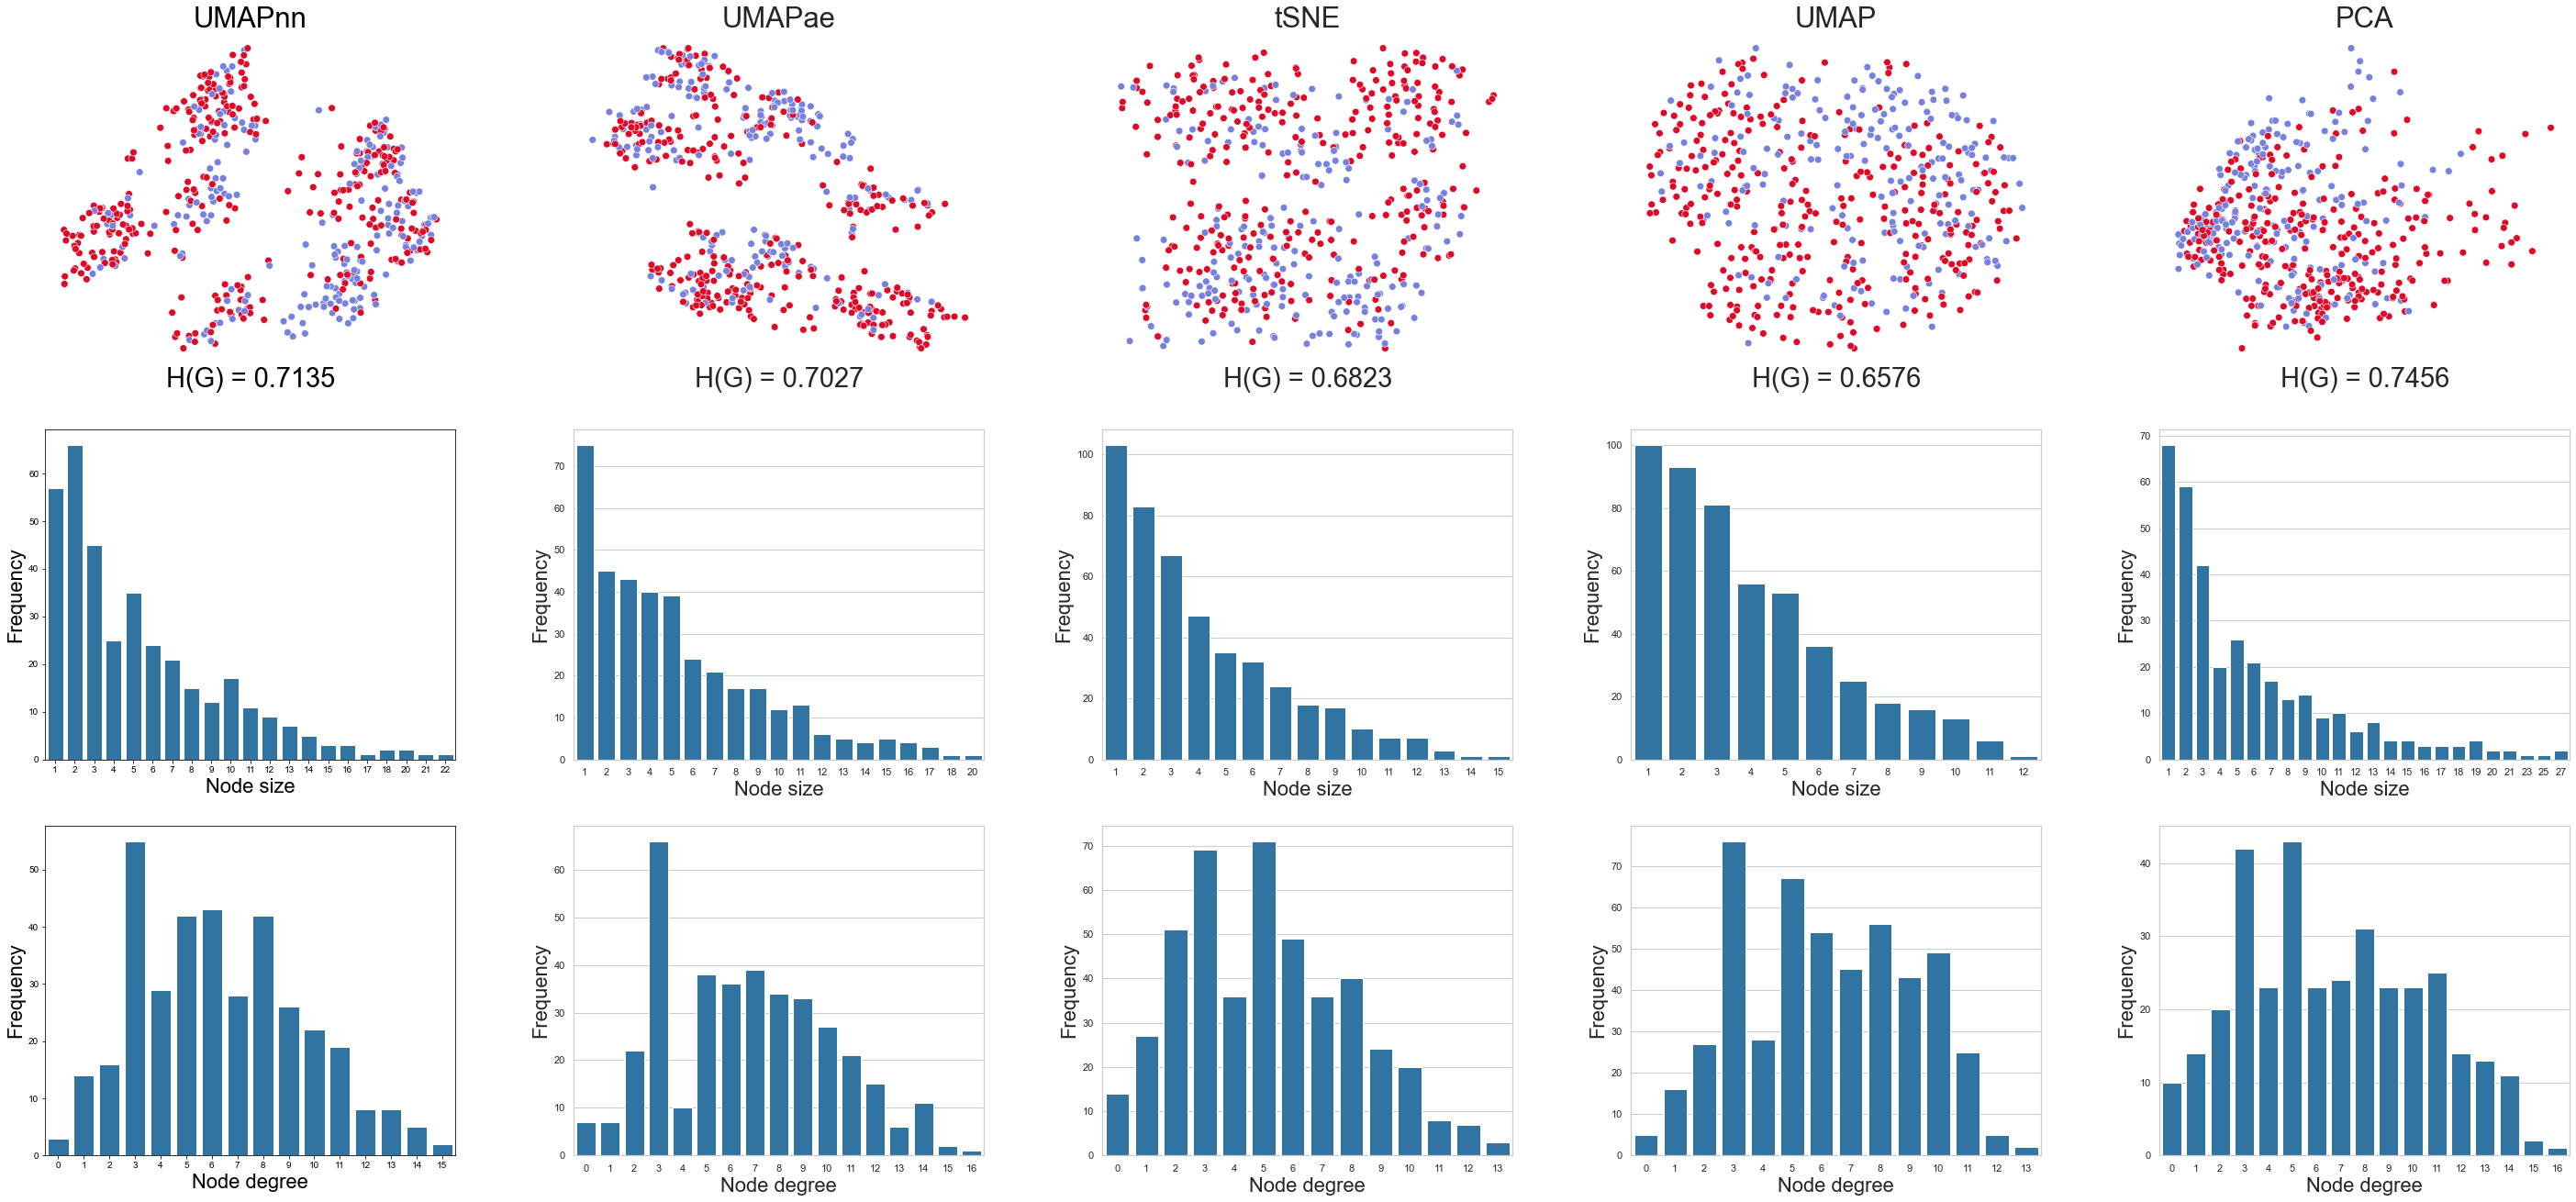

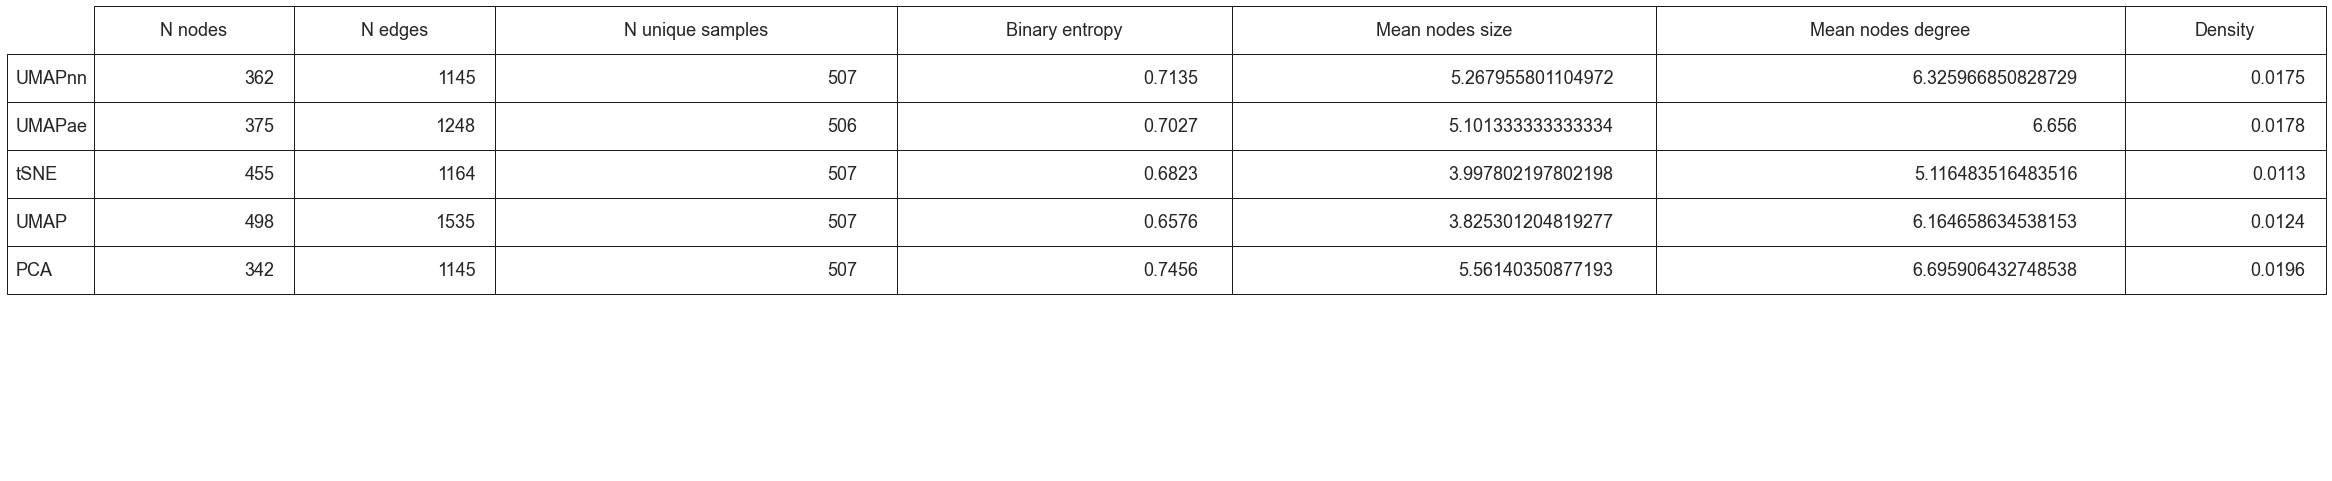

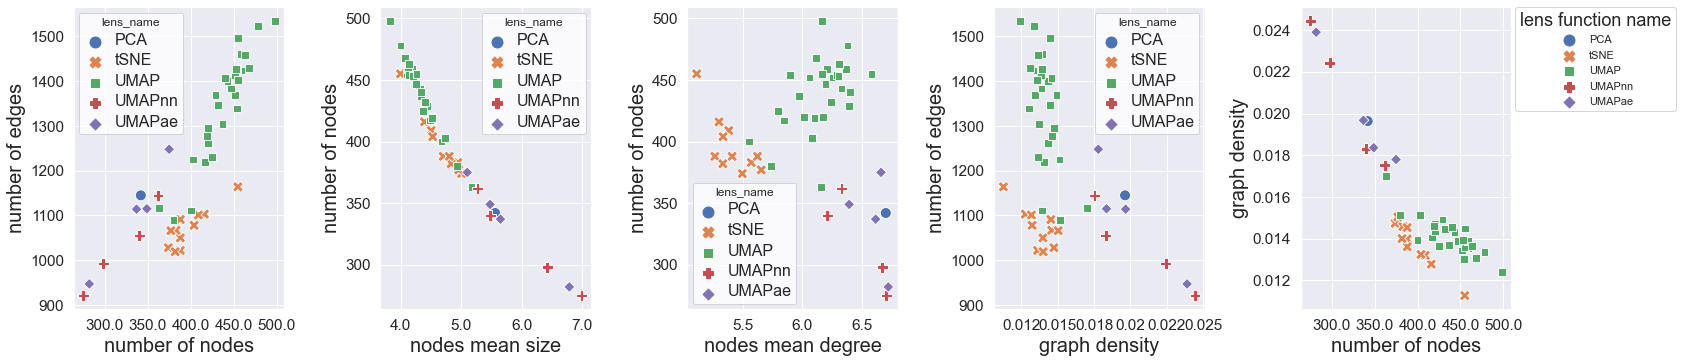

In [6]:
grid_search_results_optimal_choice("results/lens_parameters_grid_search.xlsx",trainingset_experiment['Y_class'],distance_matrix,2,203,trainingset_experiment[["CUORE_10yCV_riskscore",'Age']],False)

## Grid search (second step) for mapper parameters tuning

In [9]:
# we tune mapper parameters and implementing different clustering algorithm 
grid_search_results_df = lenses_and_hyperparameters_greedy_search(distance_matrix,
                  ['UMAP'], 2,
                  [3,4,5],[500],[0.01,0.001],
                  np.arange(15,55,10),np.arange(300,1000,300),np.array([1500]),
                  np.array([0.9]),np.array([50]),
                  np.array([100,200]),np.array([3,5]),  
                  np.array([3,4]),np.array([200,400]),       
                  np.array([14, 16, 18, 20, 22]),np.array([0.2, 0.3, 0.5, 0.6]), 
                  [DBSCAN(metric="precomputed",min_samples=2,eps=0.1,n_jobs=-1),
                   DBSCAN(metric="precomputed",min_samples=4,eps=0.1,n_jobs=-1),
                   DBSCAN(metric="precomputed",min_samples=2,eps=0.2,n_jobs=-1),
                   DBSCAN(metric="precomputed",min_samples=4,eps=0.2,n_jobs=-1),
                   DBSCAN(metric="precomputed",min_samples=2,eps=0.3,n_jobs=-1),
                   DBSCAN(metric="precomputed",min_samples=4,eps=0.3,n_jobs=-1),
                   DBSCAN(metric="precomputed",min_samples=2,eps=0.5,n_jobs=-1),
                   DBSCAN(metric="precomputed",min_samples=4,eps=0.5,n_jobs=-1),
                  AgglomerativeClustering(affinity='precomputed', linkage='complete',n_clusters=2),
                  AgglomerativeClustering(affinity='precomputed', linkage='complete',n_clusters=3),
                  SpectralClustering(n_clusters=2,assign_labels='kmeans', random_state=rnd, affinity="precomputed",n_jobs=-1),
                  SpectralClustering(n_clusters=3,assign_labels='kmeans', random_state=rnd, affinity="precomputed",n_jobs=-1)],
                  rnd,trainingset_exp1['Y_class'], trainingset_exp1[["CUORE_10yCV_riskscore",'Age']], "exp1/results/mapper_parameters_grid_search.xlsx")

lens: UMAP
min_dists: 0.9; n_neighbors: 50
n_cubes: 14;perc overlap: 0.2; cluster method: DBSCAN(eps=0.1, metric='precomputed', min_samples=2, n_jobs=-1)
n_cubes: 14;perc overlap: 0.2; cluster method: DBSCAN(eps=0.1, metric='precomputed', min_samples=4, n_jobs=-1)
n_cubes: 14;perc overlap: 0.2; cluster method: DBSCAN(eps=0.2, metric='precomputed', min_samples=2, n_jobs=-1)
n_cubes: 14;perc overlap: 0.2; cluster method: DBSCAN(eps=0.2, metric='precomputed', min_samples=4, n_jobs=-1)
n_cubes: 14;perc overlap: 0.2; cluster method: DBSCAN(eps=0.3, metric='precomputed', min_samples=2, n_jobs=-1)
n_cubes: 14;perc overlap: 0.2; cluster method: DBSCAN(eps=0.3, metric='precomputed', min_samples=4, n_jobs=-1)
n_cubes: 14;perc overlap: 0.2; cluster method: DBSCAN(metric='precomputed', min_samples=2, n_jobs=-1)
n_cubes: 14;perc overlap: 0.2; cluster method: DBSCAN(metric='precomputed', min_samples=4, n_jobs=-1)
n_cubes: 14;perc overlap: 0.2; cluster method: AgglomerativeClustering(affinity='precom

n_cubes: 16;perc overlap: 0.3; cluster method: AgglomerativeClustering(affinity='precomputed', linkage='complete',
                        n_clusters=3)
n_cubes: 16;perc overlap: 0.3; cluster method: SpectralClustering(affinity='precomputed', n_clusters=2, n_jobs=-1,
                   random_state=203)
n_cubes: 16;perc overlap: 0.3; cluster method: SpectralClustering(affinity='precomputed', n_clusters=3, n_jobs=-1,
                   random_state=203)
n_cubes: 16;perc overlap: 0.5; cluster method: DBSCAN(eps=0.1, metric='precomputed', min_samples=2, n_jobs=-1)
n_cubes: 16;perc overlap: 0.5; cluster method: DBSCAN(eps=0.1, metric='precomputed', min_samples=4, n_jobs=-1)
n_cubes: 16;perc overlap: 0.5; cluster method: DBSCAN(eps=0.2, metric='precomputed', min_samples=2, n_jobs=-1)
n_cubes: 16;perc overlap: 0.5; cluster method: DBSCAN(eps=0.2, metric='precomputed', min_samples=4, n_jobs=-1)
n_cubes: 16;perc overlap: 0.5; cluster method: DBSCAN(eps=0.3, metric='precomputed', min_samples=2,

n_cubes: 18;perc overlap: 0.6; cluster method: DBSCAN(eps=0.3, metric='precomputed', min_samples=4, n_jobs=-1)
n_cubes: 18;perc overlap: 0.6; cluster method: DBSCAN(metric='precomputed', min_samples=2, n_jobs=-1)
n_cubes: 18;perc overlap: 0.6; cluster method: DBSCAN(metric='precomputed', min_samples=4, n_jobs=-1)
n_cubes: 18;perc overlap: 0.6; cluster method: AgglomerativeClustering(affinity='precomputed', linkage='complete')
n_cubes: 18;perc overlap: 0.6; cluster method: AgglomerativeClustering(affinity='precomputed', linkage='complete',
                        n_clusters=3)
n_cubes: 18;perc overlap: 0.6; cluster method: SpectralClustering(affinity='precomputed', n_clusters=2, n_jobs=-1,
                   random_state=203)
n_cubes: 18;perc overlap: 0.6; cluster method: SpectralClustering(affinity='precomputed', n_clusters=3, n_jobs=-1,
                   random_state=203)
n_cubes: 20;perc overlap: 0.2; cluster method: DBSCAN(eps=0.1, metric='precomputed', min_samples=2, n_jobs=-1)
n_

n_cubes: 22;perc overlap: 0.3; cluster method: DBSCAN(eps=0.1, metric='precomputed', min_samples=4, n_jobs=-1)
n_cubes: 22;perc overlap: 0.3; cluster method: DBSCAN(eps=0.2, metric='precomputed', min_samples=2, n_jobs=-1)
n_cubes: 22;perc overlap: 0.3; cluster method: DBSCAN(eps=0.2, metric='precomputed', min_samples=4, n_jobs=-1)
n_cubes: 22;perc overlap: 0.3; cluster method: DBSCAN(eps=0.3, metric='precomputed', min_samples=2, n_jobs=-1)
n_cubes: 22;perc overlap: 0.3; cluster method: DBSCAN(eps=0.3, metric='precomputed', min_samples=4, n_jobs=-1)
n_cubes: 22;perc overlap: 0.3; cluster method: DBSCAN(metric='precomputed', min_samples=2, n_jobs=-1)
n_cubes: 22;perc overlap: 0.3; cluster method: DBSCAN(metric='precomputed', min_samples=4, n_jobs=-1)
n_cubes: 22;perc overlap: 0.3; cluster method: AgglomerativeClustering(affinity='precomputed', linkage='complete')
n_cubes: 22;perc overlap: 0.3; cluster method: AgglomerativeClustering(affinity='precomputed', linkage='complete',
           

In [54]:
def evaluate_seach_Mapper_parameters(path_mapper_search_results_df,dataset_len):
    """
    Function to plot and evaluate the second step of the grid search through graph statistics.
    INPUT:
       - path_mapper_search_results_df: (string) path in which the second step grid search results is saved
       - dataset_len: (int) number of samples in the dataset
    OUTPUT:
       - df_plot: (pandas DataFrame) dataframe with the combinations of mapper parameters and the graph statistics.
    """
    mapper_search_results_df = read_grid_search_results(path_mapper_search_results_df)

    resolutios = []
    gains = []
    entropy = []
    mean_degre = []
    mean_size = []
    number_of_nodes = []
    zero_degree_boolean = []
    n_unique = []
    cluster_methods = []
    additional_paramss = []
    
    for index,row in mapper_search_results_df.iterrows():
        resolutios.append(int(row['parameters_combination'].split("n_cubes: ")[1][0:2]))
        gains.append(float(row['parameters_combination'].split("perc overlap: ")[1][0:3]))
        
        cluster_method = str(row['parameters_combination'].split("cluster method: ")[1]).split("(")[0]
        additional_params = ""
        if cluster_method == "DBSCAN":
            min_sample = str(str(row['parameters_combination'].split("cluster method: ")[1]).split("(")[1]).split("min_samples=")
            eps = str(str(row['parameters_combination'].split("cluster method: ")[1]).split("(")[1]).split("eps=")
            
            if len(eps)>1:
                additional_params += " eps = " + str(eps[1]).split(",")[0]
            else:
                additional_params += " eps = " + str(0.5)
                
            
            if len(min_sample)>1:
                additional_params += " min_sample = " + str(min_sample[1]).split(",")[0]  
            else:
                additional_params += " min_sample = " + str(2)
            
        else:
            n_clusters = str(str(row['parameters_combination'].split("cluster method: ")[1]).split("(")[1]).split("n_clusters=")[0][0]
            if len(n_clusters)>1:
                additional_params = " N = " + str(n_clusters) 
            else:
                additional_params = " N = " + str(2) 
            
        additional_paramss.append(additional_params)
        cluster_methods.append(cluster_method)
        entropy.append(row['binary_cross_entropy'])
        mean_degre.append(row['mean_degree'])
        mean_size.append(row['mean_size'])
        number_of_nodes.append(row['n_nodes'])
        n_unique.append(row['n_unique'])
        
        # exclude the combinations that leads to a graph with isolated nodes
        if 0 in row['nodes_degree']:
            zero_degree_boolean.append(True)
        else:
            zero_degree_boolean.append(False)

    df_plot = pd.DataFrame({"Resolution":resolutios, "Gain":gains, "n_nodes":number_of_nodes,
                           "mean degree":mean_degre, "mean size":mean_size,
                           "zero_degree_boolean":zero_degree_boolean,"n_unique":n_unique, 
                            "cluster_methods":cluster_methods, "additional_params":additional_paramss})
    df_plot = df_plot[(df_plot['zero_degree_boolean']==False) & (df_plot['n_unique']==dataset_len)]

    # plot graph statistics and optionally incudes legend by colouring the markers according to the clustering method
    fig, ax = plt.subplots(3,2,figsize=(8,9),sharex="col",sharey="row")
    fig.tight_layout(pad=2.0)

    sb.scatterplot(data = df_plot, x = "Resolution", y = "n_nodes",hue = "cluster_methods",style = "cluster_methods",s =110 ,ax=ax[0,0],palette = "tab10",legend=False)
    sb.scatterplot(data = df_plot, x = "Gain", y = "n_nodes",hue = "cluster_methods",style = "cluster_methods",s = 110,ax=ax[0,1],palette = "tab10",legend=False)
    
    sb.scatterplot(data = df_plot, x = "Resolution", y = "mean degree",hue = "cluster_methods",style = "cluster_methods",s =110,ax=ax[1,0],palette = "tab10",legend=False)
    sb.scatterplot(data = df_plot, x = "Gain", y = "mean degree",hue = "cluster_methods",style = "cluster_methods",s =110 ,ax=ax[1,1],palette = "tab10",legend=False)
    
    sb.scatterplot(data = df_plot, x = "Resolution", y = "mean size",hue = "cluster_methods",style = "cluster_methods",s = 110,ax=ax[2,0],palette = "tab10",legend=False)
    scatter = sb.scatterplot(data = df_plot, x = "Gain", y = "mean size",hue = "cluster_methods",style = "cluster_methods",s = 110,ax=ax[2,1],palette = "tab10",legend=True)
    
    #plt.setp(scatter.get_legend().get_texts(), fontsize=18)
    #plt.legend(title = "Clustering method",bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,title_fontsize=16)
#     for lh in scatter.get_legend().legendHandles: 
#             lh._sizes = [150]       
        
    ax[2,0].set_xlabel("resolution",size=18)
    ax[2,1].set_xlabel("gain",size=18)
    ax[0,0].set_ylabel("Number of nodes",size=18)
    ax[1,0].set_ylabel("Nodes mean degree",size=18)
    ax[2,0].set_ylabel("Nodes mean size",size=18)
    ax[2,0].tick_params(axis='both', labelsize=14)
    ax[2,1].tick_params(axis='both', labelsize=14)
    ax[0,0].tick_params(axis='both', labelsize=14)
    ax[1,0].tick_params(axis='both', labelsize=14)
    ax[2,0].tick_params(axis='both', labelsize=14)
    
    plt.savefig("results/mapper_params.png",dpi=300,bbox_inches='tight')
    return df_plot

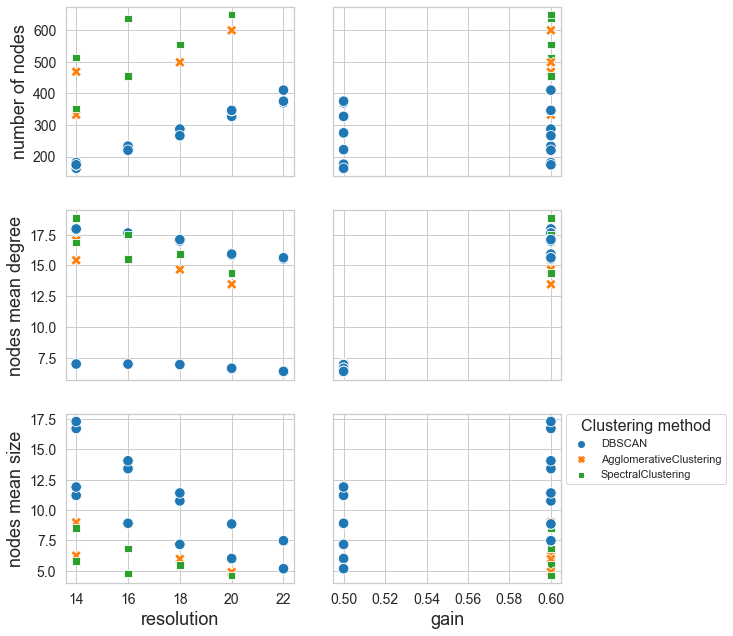

In [55]:
sb.set_style("whitegrid")
df_plot = evaluate_seach_Mapper_parameters("results/mapper_parameters.xlsx",507)

In [108]:
# we fix some thresholds and inspect the dataframe with the mapper parameters tuning results
df_plot[(df_plot['n_nodes']>=200) & (df_plot['n_nodes']<=400) & (df_plot['mean degree']>=6) & (df_plot['mean degree']<=14) & (df_plot['mean size']>=6) & (df_plot['mean size']<=12)]

,Resolution,Gain,n_nodes,mean degree,mean size,zero_degree_boolean,n_unique,cluster_methods,additional_params
74,16,0.5,222,6.936937,8.887387,False,507,DBSCAN,eps = 0.2 min_sample = 2
76,16,0.5,222,6.972973,8.909910,False,507,DBSCAN,eps = 0.3 min_sample = 2
78,16,0.5,222,6.972973,8.909910,False,507,DBSCAN,eps = 0.5 min_sample = 2
122,18,0.5,273,6.886447,7.197802,False,507,DBSCAN,eps = 0.2 min_sample = 2
124,18,0.5,275,6.938182,7.170909,False,507,DBSCAN,eps = 0.3 min_sample = 2
126,18,0.5,275,6.938182,7.170909,False,507,DBSCAN,eps = 0.5 min_sample = 2
172,20,0.5,327,6.636086,6.009174,False,507,DBSCAN,eps = 0.3 min_sample = 2
174,20,0.5,327,6.636086,6.009174,False,507,DBSCAN,eps = 0.5 min_sample = 2
